# ロジスティック回帰

ベルヌーイ分布に従う変数の統計的回帰モデルの一種．主に二値分類で使われる．

この資料では，ロジスティック回帰をスクラッチ実装し，理解することを目標とする．

なお，前提として線形回帰の知識があるとする．

---
## 本家の出力の確認

scikit-learnでの出力

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, Image, Video
import time
import random

sklearnのmake_classificationメソッドでデータを用意する．

なお．データの数は上げすぎない方が良い．\
ここでスクラッチ実装するモデルでは，データ数が多すぎると，計算量が多すぎて学習が収束しない．
その理由は後々

参考
- https://plantprogramer.com/data_generator/

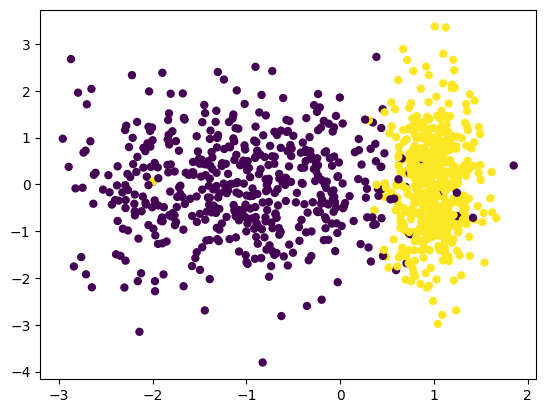

In [2]:
N = 1000 #データの数
d = 2 # 次元数
K = 2 # クラス数

X, y = make_classification(
    n_samples=N,
    n_features=d,
    n_informative=1,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=K,
    random_state=20
)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25)
plt.show()

skleanでは，どのようなハイパーパラメータがあるのかをみてみる．

興味のない人は飛ばそう．

In [3]:
model = LogisticRegression(
    penalty=None, # 正則化．(L1, L2, elasticnet)
    dual=False,
    tol=0.0001, #誤差の許容値
    C = 1.0, # 正則化の強さ
    fit_intercept= False, # バイアス項を入れるかどうか，データの質によって変える．
    intercept_scaling= 1.0, # solver='liblinear'でfit_intercept=Trueのときに発動
    class_weight=None, # クラスの数に応じて重みを受けることができる．
    random_state=None, # solver=['sag','saga','liblinear']のときにデータをシャッフルする．
    solver='newton-cg', # 最適化関数．newton-cgは，共役勾配法を導入したニュートン法のこと．
    max_iter=100, # 最大更新回数．(newton系の最適化関数は収束が早いため，更新回数は少ない．)
    multi_class='auto',
    verbose=0,
    warm_start=False, # 前のソリューションの値をそのまま持ってくる，でない場合はただ初期化するだけ
    n_jobs=None, # 使用するcpuのコア数
    l1_ratio=None # elasticnetのときの正則化割合，l1の割合を操作できる．
    )

モデルを学習させる．どのくらい学習に時間がかかるのか．などをみてみよう．

In [4]:
start = time.time()
model.fit(X,y)
end = time.time()
time_diff = end - start
print('学習にかかった時間',time_diff)
print('クラス数',model.classes_)
print('特徴量の数',model.n_features_in_)
print('coef',model.coef_.flatten())
print('intercept',model.intercept_)
print('反復数',model.n_iter_)

学習にかかった時間 0.005523204803466797
クラス数 [0 1]
特徴量の数 2
coef [3.62605703 0.07726773]
intercept [0.]
反復数 [5]


とても早く収束していることがわかる．あと，モデルに入力されたデータの詳細も確認できる．

coefは，偏回帰係数のこと．いわゆる寄与度的なところに当たる．(flatten()は，二次元配列を一次元配列に変換するメソッド．別に合ってもなくても変わらない．)

interceptはバイアス項の回帰係数．fit_intercept=Falseで実装しているのでこの値は0

一応予測値も出してみる．

In [5]:
pred = model.predict(X)
print(accuracy_score(y, pred))

0.942


※ 余計なので飛ばしてかまわない．

predict_probaというメソッドがある．

これは，各データに対して，各クラスに属する確率を出力するメソッド．

以下の値は確率になっていて，クラス0の値+クラス1の値=1で明らかにわかる通り，確率の値になっている．

In [6]:
# 少数第三位で四捨五入して表示
predict_list = np.round(model.predict_proba(X),3)
print("                                  "+"クラス0 クラス1")
for i in range(7):
    print(f"{i + 1}個目のデータに対する各クラスに属する確率", predict_list[i])

                                  クラス0 クラス1
1個目のデータに対する各クラスに属する確率 [0.057 0.943]
2個目のデータに対する各クラスに属する確率 [0.842 0.158]
3個目のデータに対する各クラスに属する確率 [0.04 0.96]
4個目のデータに対する各クラスに属する確率 [0.069 0.931]
5個目のデータに対する各クラスに属する確率 [0.894 0.106]
6個目のデータに対する各クラスに属する確率 [0.782 0.218]
7個目のデータに対する各クラスに属する確率 [0.971 0.029]


In [9]:
model.predict_proba(X)

array([[5.65956451e-02, 9.43404355e-01],
       [8.41513821e-01, 1.58486179e-01],
       [3.99359513e-02, 9.60064049e-01],
       ...,
       [5.78855132e-02, 9.42114487e-01],
       [9.99920637e-01, 7.93632630e-05],
       [2.68530605e-02, 9.73146940e-01]])

---
## 理論
ロジスティック回帰の気持ち，流れを先に整理する

### イメージで理解する

ベースは線形回帰である．これを二値分類に適用できるように，工夫をしていく．

まず線形回帰のイメージをつかもう．

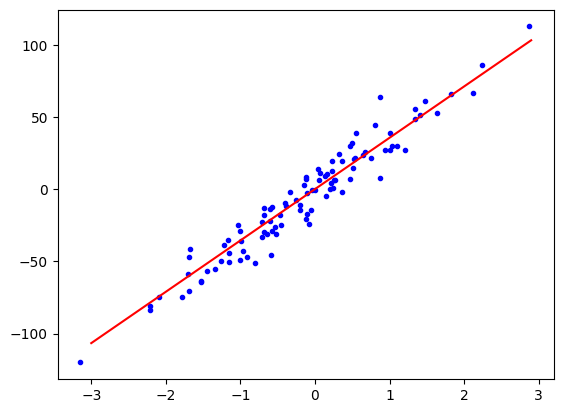

In [8]:
from sklearn.datasets import make_regression

x_reg, y_reg, coef_reg = make_regression(
    random_state = 12,
    n_samples=100,
    n_features=1,
    n_informative=1,
    noise=10.0,
    bias=-0.0,
    coef=True
)

x0 = np.arange(-3, 3, 0.1)

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg, marker='.', color='blue')
plt.plot(x0, x0*coef_reg, color='red')
plt.plot()
plt.show()

このデータのフィットした直線が線形回帰である，

では二値分類はどのようなデータだろうか？

二値分類のデータは，以下のようなデータである．

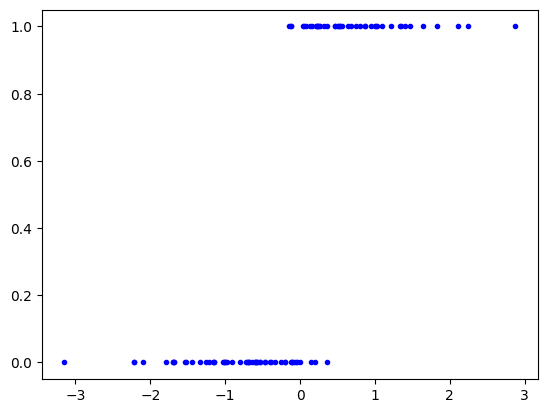

In [9]:
y_reg_0or1 = y_reg[:]

for i in range(len(y_reg_0or1)):
    if y_reg_0or1[i] > 0:
        y_reg_0or1[i] = 1
    else:
        y_reg_0or1[i] = 0

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg_0or1, marker='.', color='blue')
plt.plot()
plt.show()

これは先ほどのデータを0.5を境界に，0と1に分けたものである．二値分類ではこのようなデータを扱う．

ここに線形回帰のように直線を引いて適切な予測ができるだろうか？

どう考えても無理．だから工夫をする．

線形回帰の直線を曲げる．(この操作をロジスティック変換と言う．あとで詳しく説明する．)

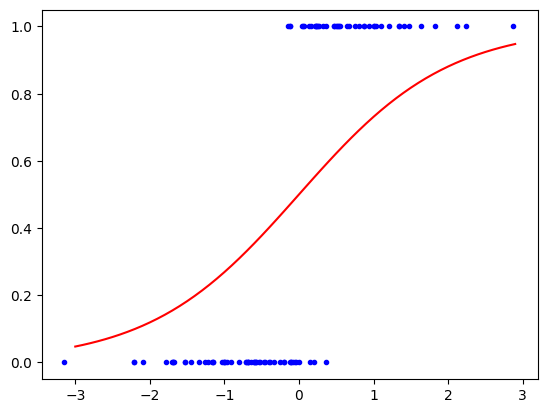

In [10]:
def sigmoid_method(x, gain):
    return 1 / (1 + np.exp(-x * gain))

sigmoid_x = np.arange(-3, 3, 0.1)

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg_0or1, marker='.', color='blue') #なぜかmarkerだけだと点が繋がる
plt.plot(sigmoid_x, sigmoid_method(sigmoid_x, gain=1), color='red')
plt.plot()
plt.show()

ロジスティック変換でこのようにデータにある程度フィットした曲線ができる．

しかし，今のままではパラメータが最適ではないせいで，データへの当てはまりが弱い．

いい感じのパラメータを当てはめると以下のようになる．

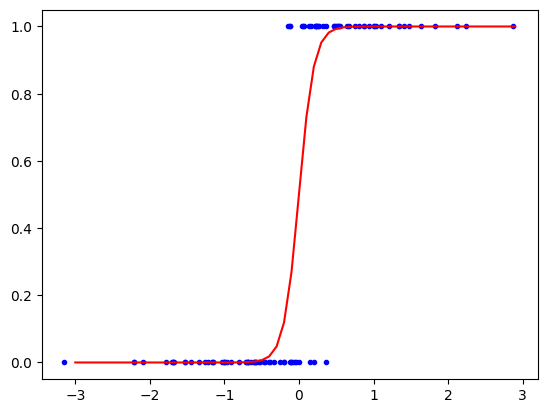

In [11]:
def sigmoid_method(x, gain):
    return 1 / (1 + np.exp(-x * gain))

sigmoid_x = np.arange(-3, 3, 0.1)

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg_0or1, marker='.', color='blue')
plt.plot(sigmoid_x, sigmoid_method(sigmoid_x, gain=10), color='red')
plt.plot()
plt.show()

これで二値データにフィットした曲線ができた．

このようにして二値分類を実現する．

※ これはシグモイド関数を使っている．ここで，step関数ではダメなのかと思うかもしれないが，sklearnの出力で確認したように，確率を出力する必要があるため，step関数は適さない．

ひとまずイメージは掴めた．あとはどうやるのかを数学的に追う．

### 数学で理解する

$n$:データ数\
$m$:次元数\
$X\in \mathbb{R}^{n\times m}$:説明変数\
$\boldsymbol{y}\in \mathbb{R}^{n}$:目的変数\
$\boldsymbol{w}\in \mathbb{R}^{m}$:パラメータ

今やったことを数式で説明しよう．\
まず線形回帰の式を用意する．
$$
X\boldsymbol{w}
$$
これだね．\
次にsigmoid関数を用意する．
$$
\sigma(x) = \frac{1}{1-e^{-x}}
$$
そしてsigmoid関数に線形回帰の式を代入する．
$$
\boldsymbol{\hat{y}} = \frac{1}{1-e^{-X\boldsymbol{w}}} \\
$$
これで出力値が**ほぼ二値**(0,1)のモデルができた．\
ほぼ二値なのはsigmoid関数の形を見れば明らか．\
そこで最終的にはsigmoid関数の出力を0.5を基準に二値に分ける操作が必要である．別に大したことではないね．

そして，この後に適切なパラメータを求める．

では，適切なパラメータ$\boldsymbol{w}$を求めていこう．\
しかし，(おそらく)最小二乗法は使えない．\
その理由を整理する．

目的変数は二値である．\
ということは予測値も二値で出力することになる．以下の損失関数は適切か？\
残差を$\boldsymbol{J}\in \mathbb{R}^{n×1}$とする．
$$
\begin{align}
\boldsymbol{J} &= \|\boldsymbol{y}-\boldsymbol{\hat{y}}\|_2^2 \\
&= \|\boldsymbol{y}-\frac{1}{1-e^{-X\boldsymbol{w}}} \|_2^2

\end{align}
$$
正直自分が数学ができないのでこれがダメな理由をはっきりということができない．\
しかし，少なくともこれよりも適切な損失関数は存在する．

※一応最小二乗法を使えない理由を一つ述べる．\
　最小二乗法は実測値$\boldsymbol{y}$が正規分布に従うと仮定して最尤推定を進めると出てくる手法である。\
　今回の目的変数は二値なので試行回数1回の二項分布，したがってベルヌーイ分布と捉えられる．\
　今回は実測値$\boldsymbol{y}$は正規分布だと仮定できないので，パラメータの点推定に**最尤法**を使用する．

細かいことは置いておいて，尤度を$L$としたとき，以下のようになる．\
二値データ$Y$が$Y=1$となる確率を$P=p(Y=1)$，$Y=0$となる確率を$1-P=p(Y=0)$とする．\
$Y(Y_1,Y_2,...,Y_N)$が独立であり，$p(Y_i=1)=P_i$であるとき尤度$L$は以下になる．\
※実測値を$Y$としているが，大文字であることに特に意味はない，ただ0,1しかとらないため，普段扱う連続値の$y$と区別したいため大文字にした．
$$
L = \prod_{i=1}^N P_i^{Y_i}(1-P_i)^{1-Y_i}
$$
$Y_i=1$のとき，$P_i^{Y_i}$が残って，$Y_i=0$のとき$(1-P_i)^{1-Y_i}$が残る．ただそれを表しているだけ．

お決まりのとおり対数尤度をとる．計算しやすいから．
$$
\begin{align}
log(L) &= log(\prod_{i=1}^N P_i^{Y_i}(1-P_i)^{1-Y_i}) \\
&= \sum_{i=1}^{N}(Y_i logP_i+(1-Y_i)log(1-P_i))\\
\end{align}
$$
この対数尤度を最大化する．\
$P_i$を以下とする．$\hat{y}_i$を$P_i$としたのは，確率と関係があるから．普通に予測値として捉えてもらって問題ない．
$$
P_i = \hat{y}_i = \sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)
$$
そして，負の対数尤度を$E(\boldsymbol{w})$として$E(\boldsymbol{w})$を最小化することを考える．
$$
E(\boldsymbol{w})=-\log (L) = \sum_{i=1}^{N}(Y_i \log \sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)+(1-Y_i)\log(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)))
$$
したがって，この最適値をニュートン法によって求める．
$$
\nabla E(\boldsymbol{w})=0
$$
を求めていく．(勾配が$0$になる点を求めていくということ．)\
ちなみに$\nabla E(\boldsymbol{w}^{old})$はただの一階微分

### ニュートン法

$$
\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})
$$
これがパラメータ$\boldsymbol{w}$の更新式である．これを繰り返すことで自ずと適切なパラメータが求められる．\
これを解いていくためには$H$，ヘッセ行列が必要である．

一旦，イメージが掴みやすいようにニュートン法によって$(x - 1)^2$の解を近似的に求めてみる．\
このときのニュートン法の式は以下
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}
$$

実際にニュートン法で$(x-1)^2$を近似してみる．\
ニュートン法の更新式の部分は具体的に以下のようになっている．
$$
x^{new} = x^{old} - \frac{(x-1)^2}{2x}
$$

In [12]:
x = 3.0
for i in range(1000):
    x_new = x - (x-1)**2 / (x * 2)
    if abs(x_new - x) < 0.000001:
        break
    x = x_new
print(x)

1.002012600455359


グラフにするとこれ(githubから動画は見れないので手元で実行してみて欲しい．)

In [13]:
# 近似したい関数
def here_function(x):
    y = (x - 1) ** 2
    return y

# 0を返すだけの関数，xの位置がわかりやすくするため．
def zero_function(x):
    return 0

def diff(diff ,x ,x0 ,intercept):
    return 2 * diff * (x-x0) + intercept

def here_function_derivative(x):
    return 2 * (x - 1)

start = 0 #定義域の左端
last = 6 # 定義域の右端

x0 = np.arange(start,last, 0.01)
y0 = here_function(x0)
x1 = np.arange(0,8, 0.01)

fig = plt.figure() # Figureオブジェクトを作成
ax = fig.add_subplot(1,1,1) # figに属するAxesオブジェクトを作成
#ax.set_aspect('equal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlim(-1,7)
ax.set_ylim(-1,26)
ax.grid() # グラフにグリッドを追加


dx = 0.1
ax.plot(x0, y0)

artist_list = []
point_list_x = []
point_list_y = []
point_list_0 = []

x_ = 6.0
x_new = np.inf
for i in range(150):
    y_ = here_function(x_)
    zero = zero_function(x)

    # ニュートン法
    x_new = x_ - y_ / here_function_derivative(x_)
    if abs(x_new - x_) < 0.001:
        break
    point_list_x.append(x_)
    point_list_y.append(y_)
    point_list_0.append(zero)

    art = plt.plot(point_list_x, point_list_y, marker='.', markersize=10, color='red', linestyle='None')
    art += plt.plot(point_list_x, point_list_0, marker='.', markersize=10, color='red',linestyle='None')
    art += plt.plot(x1, diff(here_function_derivative(x_new),x1,x_, y_), marker='.',markersize=1 ,color='pink',linestyle='None')

    artist_list.append(art)
    x_ = x_new

ani = ArtistAnimation(fig, artist_list, interval = 200)

plt.close()
HTML(ani.to_jshtml())
# ani.save('anim.gif', writer="imagemagick")

ニュートン法のイメージが掴めた．ということで$\boldsymbol{w}^{new}$についても同様に理解したい．\
ニュートン法の式と今回使う式の対応を考えよう．\
今回の式は以下
$$
\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})
$$
ニュートン法の式は以下
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}
$$
一見何が対応しているのかわからないが，整理していく．\
$H^{-1}$はヘッセ行列(二階微分)の逆行列であり．$\frac{1}{f'(x_1)}$に対応する．$f'(x)^{-1}$と書くとわかりやすい．\
$\nabla E(\boldsymbol{w}^{old})$はただの一階微分であり，$f(x_1)$に対応する．

今回は最終的に$\nabla E(\boldsymbol{w})\simeq 0$をニュートン法で目指している．

では，この更新式$\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})$に当てはまる具体的な数値を求めていこう．

### 具体的な数値へ展開

重みベクトル$\boldsymbol{w}$はベクトルとしてすでにある．\
わからないのは$H$と$\nabla E$だけ．こいつらを求める．そのために必要な材料は以下．
- シグモイド関数$\sigma$の微分}
- $E(\boldsymbol{w})$の一階微分(これが$\nabla E(\boldsymbol{w}$))

**シグモイド関数の微分**

$t=w^{T}x_i$とおく．
$$
\frac{d}{dt}\sigma(t) = (1+e^{-t})^{-1}
$$
ここで，$u=(1+e^{-t})$とおく．\
合成関数の微分より
$$
\begin{align}
\frac{d}{dt}\sigma(t)&=\frac{d}{du}u^{-1}\frac{du}{dt}u\\
&=-u^{-2}\frac{du}{dt}(1+e^{-t})\\
&=-(1+e^{-t})^{-2}\cdot-e^{-t}\\
\end{align}
$$
※補足としてe^{-t}の微分(わかっている人は次に進もう)\
T=-tとおく\
合成関数の微分より
$$
\begin{align}
\frac{d}{dt}(e^{-t})&=\frac{d}{dT}(e^{T})\frac{dT}{dt}T\\
&=e^{T}\frac{d}{dt}(-t)\\
&=e^{-t}\cdot-1\\
&=-e^{-t}
\end{align}
$$
さっきの途中から
$$
\begin{align}
\frac{d}{dt}\sigma(t)&=-(1+e^{-t})^{-2}\cdot-e^{-t}\\
&=\frac{e^{-t}}{(1+e^{-t})^{2}}\\
&=\frac{e^{-t}}{1+e^{-t}}\frac{1}{1+e^{-t}}\\
&=(\frac{1+e^{-t}}{1+e^{-t}}-\frac{1}{1+e^{-t}})\frac{1}{1+e^{-t}}\\
\frac{d}{dt}\sigma(t)&=(1-\sigma(t))\sigma(t)
\end{align}
$$
これでシグモイド関数の微分を求めることができた．(これは後々何回か出てくる．)

**$E(\boldsymbol{w})$の一階微分($\nabla E(\boldsymbol{w}$))**

$$
\nabla E(\boldsymbol w) = -\sum_{i=1}^n[y_i\nabla\log \sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)+(1-y_i)\nabla\log (1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))]
$$
$\frac{d}{dt}\log t=\frac1t$より
$$
= -\sum_{i=1}^n[y_i\frac{1}{\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)}\nabla\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)
+
(1-y_i)\frac{1}{1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)}\nabla (1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))]
$$
シグモイド関数の微分より
$$
\begin{align}
&= -\sum_{i=1}^n[y_i\frac{1}{\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)}\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))\boldsymbol{x}_i
+
(1-y_i)\frac{1}{1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)}(-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)))\boldsymbol{x}_i]\\

&= -\sum_{i=1}^n[y_i(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))\boldsymbol{x}_i
+
(1-y_i)(-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)\boldsymbol{x}_i]\\

&= -\sum_{i=1}^n[y_i-y_i\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)
-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)+y_i\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)]\boldsymbol{x}_i\\

&= -\sum_{i=1}^n[y_i-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)]\boldsymbol{x}_i\\

&= \sum_{i=1}^n(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-y_i)\boldsymbol{x}_i\\
\end{align}
$$
$\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-y_i$はスカラーで$\boldsymbol{x}_i$は$m$次元の行ベクトルである．したがって$\sum_{i=1}^n[\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-y_i]\boldsymbol{x}_i$の意味は$\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-y_i$倍された$\boldsymbol{x}_i$ベクトルをを$n$について足し合わせたものである．

行列を使用することで$\sum_{i=1}^n[\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-y_i]\boldsymbol{x}_i$の$\sum$を消すことができる．そうすることでもっとシンプルに表すことができる．\
ここで表記を簡単にするために$\hat{y}_i=\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)$とする．上の方で$P_i=\hat{y}_i=\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)$とも言っていたけど，今回は予測値という意味合いがメインなので$\hat{y}$を使わせてもらう．
$$
\sum_{i=1}^n(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-y_i)\boldsymbol{x}_i
=\sum_{i=1}^n(\hat{y}_i-y_i)\boldsymbol{x}_i\\
=\begin{bmatrix}
(\hat{y}_1-y_1)x_{11} + (\hat{y}_2-y_2)x_{21} + \cdots + (\hat{y}_n-y_n)x_{n1}\\
(\hat{y}_1-y_1)x_{12} + (\hat{y}_2-y_2)x_{22} + \cdots + (\hat{y}_n-y_n)x_{n2}\\
\vdots\\
(\hat{y}_1-y_1)x_{1m} + (\hat{y}_2-y_2)x_{2m} + \cdots + (\hat{y}_n-y_n)x_{nm}\\
\end{bmatrix}
$$
これは行列$X$とベクトル$(\boldsymbol{\hat{y}}-\boldsymbol{y})$との内積で表すと
$$
\sum_{i=1}^n(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-y_i)\boldsymbol{x}_i
=\sum_{i=1}^n(\hat{y}_i-y_i)\boldsymbol{x}_i\\
=\begin{bmatrix}
x_{11} & x_{21} & \cdots & x_{n1}\\
x_{12} & x_{22} & \cdots & x_{n2}\\
\vdots & \vdots &\ddots & \vdots\\
x_{1m} & x_{2m} & \cdots & x_{nm}\\
\end{bmatrix}
(\boldsymbol{\hat{y}}-\boldsymbol{y})
$$

$$
\nabla E(\boldsymbol{w})=X^{T}(\boldsymbol{\hat{y}}-\boldsymbol{y})
$$
これで一階微分を求めることができた．

※補足
$$
\begin{align}
\frac{\partial}{\partial\boldsymbol{w}}\boldsymbol{w}^{T}\boldsymbol{x}_i
&=
\frac{\partial}{\partial\boldsymbol{w}}
\begin{bmatrix}
w_1 & w_2 & \cdots & w_m
\end{bmatrix}
\begin{bmatrix}
x_{i1} \\ x_{i2} \\ \vdots \\ x_{im}
\end{bmatrix}\\
&=
\frac{\partial}{\partial\boldsymbol{w}}\begin{bmatrix}
x_{i1}w_1 + x_{i2}w_2 + \cdots + x_{im}w_m
\end{bmatrix}\\
&=
\begin{bmatrix}
\frac{\partial}{\partial{w_1}}(x_{i1}w_1+&x_{i2}w_2+&\cdots&+x_{im}w_m)\\
\frac{\partial}{\partial{w_2}}(x_{i1}w_1+&x_{i2}w_2+&\cdots&+x_{im}w_m)\\
& \vdots\\
\frac{\partial}{\partial{w_m}}(x_{i1}w_1+&x_{i2}w_2+&\cdots&+x_{im}w_m)
\end{bmatrix}\\
&=
\begin{bmatrix}
x_{i1}\\
x_{i2}\\
\vdots\\
x_{im}
\end{bmatrix}\\
&=
\boldsymbol{x}_i
\end{align}
$$

$$
\nabla E(\boldsymbol{w})=
\begin{bmatrix}
(\hat{y}_1-y_1)x_{11} + (\hat{y}_2-y_2)x_{21} + \cdots + (\hat{y}_n-y_n)x_{n1}\\
(\hat{y}_1-y_1)x_{12} + (\hat{y}_2-y_2)x_{22} + \cdots + (\hat{y}_n-y_n)x_{n2}\\
\vdots\\
(\hat{y}_1-y_1)x_{1m} + (\hat{y}_2-y_2)x_{2m} + \cdots + (\hat{y}_n-y_n)x_{nm}\\
\end{bmatrix}
$$
$\nabla E(\boldsymbol{w})=\mathbb{R}^{m}$

$\hat{y}_i=\sigma(\boldsymbol{w}^T\boldsymbol{x}_i)$

**ヘッセ行列(二階微分)の導出**

先ほど求められた勾配，$\nabla E(\boldsymbol{w})$を微分して，二階微分を求める．

$$
\begin{align*}
\frac{\partial}{\partial \boldsymbol{w}}\nabla E(\boldsymbol{w}) &= \frac{\partial}{\partial \boldsymbol{w}} \{ X^{T}(\boldsymbol{\hat{y}} - \boldsymbol{y})\}\\
&= \frac{\partial}{\partial \boldsymbol{w}} (X^{T}\boldsymbol{\hat{y}} - X^{T}\boldsymbol{y})\\
\end{align*}
$$

$X^{T}\boldsymbol{y}$は，$\boldsymbol{w}$によらない項なので，微分すると0になる．\
したがって，$X^{T}\boldsymbol{\hat{y}}$のみが残る．

$$
\begin{align*}
&= \frac{\partial}{\partial \boldsymbol{w}} X^{T}\boldsymbol{\hat{y}}\\
\end{align*}
$$

問題は，$X^{T}\boldsymbol{\hat{y}}$の微分だけになった．

連載律より，
$$
\begin{align*}
\frac{\partial}{\partial \boldsymbol{w}} X^{T}\boldsymbol{\hat{y}}
&=\frac{\partial}{\partial \boldsymbol{\hat{y}}} X^{T}\boldsymbol{\hat{y}}\frac{\partial \boldsymbol{\hat{y}}}{\partial \boldsymbol{w}}\\
\end{align*}
$$

これを計算していくにあたり，注意すべき点が，ヤコビ行列の定義と，行列形状である．

ベクトルをベクトルで微分すると行列になるのだが，今回の場合，$X^{T}\boldsymbol{\hat{y}} \in \mathbb{R}^m$を，$\boldsymbol{\hat{y}} \in \mathbb{R}^n$に関して微分するので，微分後の行列形状は，$\mathbb{R}^{m\times n}$か，$\mathbb{R}^{n\times m}$になる．これはどちらに合わせれば良いのだろうか？

そこで，ヤコビ行列を以下のように定義する．

$\boldsymbol{a} \in \mathbb{R}^m$\
$\boldsymbol{b} \in \mathbb{R}^n$
とする．
$$
\begin{align*}
\frac{\partial \boldsymbol{a}}{\partial \boldsymbol{b}}
&=
\begin{bmatrix}
\frac{\partial a_1}{\partial b_1} & \frac{\partial a_1}{\partial b_2} & \cdots & \frac{\partial a_1}{\partial b_n}\\
\frac{\partial a_2}{\partial b_1} & \frac{\partial a_2}{\partial b_2} & \cdots & \frac{\partial a_2}{\partial b_n}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial a_m}{\partial b_1} & \frac{\partial a_m}{\partial b_2} & \cdots & \frac{\partial a_m}{\partial b_n}\\
\end{bmatrix}
\end{align*}
$$

行列形状は，$\mathbb{R}^{m\times n}$になる．これを利用して，$\frac{\partial}{\partial \boldsymbol{\hat{y}}} X^{T}\boldsymbol{\hat{y}}$を計算する．\
※ 普通にググって出てくるヤコビ行列の定義はこれ．しかし，RRMLでは逆になっている(はず)なので注意．ヤコビ行列の形状が逆だと，ヤコビ行列の性質を利用した公式も逆になるからね．

順番に
$
\frac{\partial}{\partial \boldsymbol{\hat{y}}} X^{T}\boldsymbol{\hat{y}}\frac{\partial \boldsymbol{\hat{y}}}{\partial \boldsymbol{w}}\\
$を解いていく．

まず，$\frac{\partial}{\partial \boldsymbol{\hat{y}}} X^{T}\boldsymbol{\hat{y}}$を計算する．

今回のヤコビ行列であれば，$\frac{\partial}{\partial \boldsymbol{\hat{y}}} X^{T}\boldsymbol{\hat{y}}=X^T$になる．これを確認する．

※ ヤコビ行列が$\mathbb{R}^{n\times m}$の場合，$\frac{\partial}{\partial \boldsymbol{\hat{y}}} X^{T}\boldsymbol{\hat{y}}=X$になる．


$$
\begin{align*}
\frac{\partial}{\partial \boldsymbol{\hat{y}}} X^{T}\boldsymbol{\hat{y}}
&=
\frac{\partial}{\partial \boldsymbol{\hat{y}}}
\{
\begin{bmatrix}
X_{11} & X_{21} & \cdots & X_{n1}\\
X_{12} & X_{22} & \cdots & X_{n2}\\
\vdots & \vdots & \ddots & \vdots \\
X_{1m} & X_{2m} & \cdots & X_{nm}\\
\end{bmatrix}
\begin{bmatrix}
\hat{y}_{1}\\
\hat{y}_{2}\\
\vdots\\
\hat{y}_{n}\\
\end{bmatrix}
\}
\\
&=
\frac{\partial}{\partial \boldsymbol{\hat{y}}}
\begin{bmatrix}
X_{11}\hat{y}_{1} + X_{21}\hat{y}_{2} + \cdots + X_{n1}\hat{y}_{n}\\
X_{12}\hat{y}_{1} + X_{22}\hat{y}_{2} + \cdots + X_{n2}\hat{y}_{n}\\
\vdots \\
X_{1m}\hat{y}_{1} + X_{2m}\hat{y}_{2} + \cdots + X_{nm}\hat{y}_{n}\\
\end{bmatrix}\\
&=
\frac{\partial}{\partial \boldsymbol{\hat{y}}}
\begin{bmatrix}
\sum_{i=1}^{n} X_{i1}\hat{y}_{i}\\
\sum_{i=1}^{n} X_{i2}\hat{y}_{i}\\
\vdots\\
\sum_{i=1}^{n} X_{im}\hat{y}_{i}\\
\end{bmatrix}\\
&=
\begin{bmatrix}
\frac{\partial \sum_{i=1}^{n} X_{i1}\hat{y}_{i}}{\partial \hat{y_1}} &
\frac{\partial \sum_{i=1}^{n} X_{i1}\hat{y}_{i}}{\partial \hat{y_2}} &
\cdots &
\frac{\partial \sum_{i=1}^{n} X_{i1}\hat{y}_{i}}{\partial \hat{y_n}}
\\
\frac{\partial \sum_{i=1}^{n} X_{i2}\hat{y}_{i}}{\partial \hat{y_1}} &
\frac{\partial \sum_{i=1}^{n} X_{i2}\hat{y}_{i}}{\partial \hat{y_2}} &
\cdots &
\frac{\partial \sum_{i=1}^{n} X_{i2}\hat{y}_{i}}{\partial \hat{y_n}}
\\
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial \sum_{i=1}^{n} X_{im}\hat{y}_{i}}{\partial \hat{y_1}} &
\frac{\partial \sum_{i=1}^{n} X_{im}\hat{y}_{i}}{\partial \hat{y_2}} &
\cdots &
\frac{\partial \sum_{i=1}^{n} X_{im}\hat{y}_{i}}{\partial \hat{y_n}}
\\
\end{bmatrix}\\

\end{align*}
$$

ヤコビ行列ができた．

試しに，この行列の1行1列目を計算してみる．($\hat{y}_1$の係数が出てくる．)

$$
\begin{align*}
\frac{\partial \sum_{i=1}^{n} X_{i1}\hat{y}_{i}}{\partial \hat{y_1}}
&=
\frac{\partial}{\partial \hat{y_1}}\sum_{i=1}^{n} X_{i1}\hat{y}_{i}\\
&=
\frac{\partial}{\partial \hat{y_1}}( X_{11}\hat{y}_{1} + X_{21}\hat{y}_{2} + \cdots + X_{n1}\hat{y}_{n})\\
&=
X_{11}
\end{align*}
$$

1行2列目も計算してみる．($\hat{y}_2$の係数が出てくる．)

$$
\begin{align*}
\frac{\partial \sum_{i=1}^{n} X_{i1}\hat{y}_{i}}{\partial \hat{y_2}}
&=
\frac{\partial}{\partial \hat{y_2}}\sum_{i=1}^{n} X_{i1}\hat{y}_{i}\\
&=
\frac{\partial}{\partial \hat{y_2}}( X_{11}\hat{y}_{1} + X_{21}\hat{y}_{2} + \cdots + X_{n1}\hat{y}_{n})\\
&=
X_{21}
\end{align*}
$$

他の要素も同様に計算できる．

これを全て計算する．

$$
\begin{align*}

\begin{bmatrix}
\frac{\partial \sum_{i=1}^{n} X_{i1}\hat{y}_{i}}{\partial \hat{y_1}} &
\frac{\partial \sum_{i=1}^{n} X_{i1}\hat{y}_{i}}{\partial \hat{y_2}} &
\cdots &
\frac{\partial \sum_{i=1}^{n} X_{i1}\hat{y}_{i}}{\partial \hat{y_n}}
\\
\frac{\partial \sum_{i=1}^{n} X_{i2}\hat{y}_{i}}{\partial \hat{y_1}} &
\frac{\partial \sum_{i=1}^{n} X_{i2}\hat{y}_{i}}{\partial \hat{y_2}} &
\cdots &
\frac{\partial \sum_{i=1}^{n} X_{i2}\hat{y}_{i}}{\partial \hat{y_n}}
\\
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial \sum_{i=1}^{n} X_{im}\hat{y}_{i}}{\partial \hat{y_1}} &
\frac{\partial \sum_{i=1}^{n} X_{im}\hat{y}_{i}}{\partial \hat{y_2}} &
\cdots &
\frac{\partial \sum_{i=1}^{n} X_{im}\hat{y}_{i}}{\partial \hat{y_n}}
\\
\end{bmatrix}
&=
\begin{bmatrix}
X_{11} & X_{21} & \cdots & X_{n1}\\
X_{12} & X_{22} & \cdots & X_{n2}\\
\vdots & \vdots & \ddots & \vdots\\
X_{1m} & X_{2m} & \cdots & X_{nm}\\
\end{bmatrix}\\
&=X^T
\end{align*}
$$

したがって，

$$
\frac{\partial}{\partial \boldsymbol{\hat{y}}} X^{T}\boldsymbol{\hat{y}}=X^T
$$


次に，
$\frac{\partial \boldsymbol{\hat{y}}}{\partial \boldsymbol{w}}$を計算する．

最初にヤコビ行列の形にした方がわかりやすいので，行列にして，各要素について計算する．

$$
\begin{align*}
\frac{\partial \boldsymbol{\hat{y}}}{\partial \boldsymbol{w}}
&=
\begin{bmatrix}
\frac{\partial \hat{y}_1}{\partial w_1} & \frac{\partial \hat{y}_1}{\partial w_2} & \cdots & \frac{\partial \hat{y}_1}{\partial w_m}\\
\frac{\partial \hat{y}_2}{\partial w_1} & \frac{\partial \hat{y}_2}{\partial w_2} & \cdots & \frac{\partial \hat{y}_2}{\partial w_m}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial \hat{y}_n}{\partial w_1} & \frac{\partial \hat{y}_n}{\partial w_2} & \cdots & \frac{\partial \hat{y}_n}{\partial w_m}\\
\end{bmatrix}
\end{align*}
$$

この行列の1行1列目を計算してみる．

$\hat{y}_1 = \sigma(\boldsymbol{w}^T\boldsymbol{x}_1)$\
※ $\boldsymbol{x}_1 =
\begin{bmatrix}
x_{11}\\
x_{12}\\
\vdots\\
x_{1m}
\end{bmatrix}$\
シグモイド関数の微分は，$\sigma(t)(1-\sigma(t))$なので，

$$
\begin{align*}
\frac{\partial \hat{y}_1}{\partial w_1}
&=
\frac{\partial}{\partial w_1}\sigma(\boldsymbol{w}^T\boldsymbol{x}_1)\\
&=
\frac{\partial}{\partial w_1}\sigma(w_1x_{11}+w_2x_{12}+\cdots+w_mx_{1m})\\
&=
\sigma(\boldsymbol{w}^T\boldsymbol{x}_1)(1-\sigma(\boldsymbol{w}^T\boldsymbol{x}_1))x_{11}\\
&=
\hat{y}_1(1-\hat{y}_1)X_{11}
\end{align*}
$$

1行2列目も計算してみる．

$$
\begin{align*}
\frac{\partial \hat{y}_1}{\partial w_2}
&=
\frac{\partial}{\partial w_2}\sigma(\boldsymbol{w}^T\boldsymbol{x}_1)\\
&=
\frac{\partial}{\partial w_2}\sigma(w_1x_{11}+w_2x_{12}+\cdots+w_mx_{1m})\\
&=
\sigma(\boldsymbol{w}^T\boldsymbol{x}_1)(1-\sigma(\boldsymbol{w}^T\boldsymbol{x}_1))x_{12}\\
&=
\hat{y}_1(1-\hat{y}_1)X_{12}
\end{align*}
$$

他の要素も同様に計算できる．

これを全て計算する．

$$
\begin{align*}
\begin{bmatrix}
\frac{\partial \hat{y}_1}{\partial w_1} & \frac{\partial \hat{y}_1}{\partial w_2} & \cdots & \frac{\partial \hat{y}_1}{\partial w_m}\\
\frac{\partial \hat{y}_2}{\partial w_1} & \frac{\partial \hat{y}_2}{\partial w_2} & \cdots & \frac{\partial \hat{y}_2}{\partial w_m}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{\partial \hat{y}_n}{\partial w_1} & \frac{\partial \hat{y}_n}{\partial w_2} & \cdots & \frac{\partial \hat{y}_n}{\partial w_m}\\
\end{bmatrix}
&=
\begin{bmatrix}
\hat{y}_1(1-\hat{y}_1)X_{11} & \hat{y}_1(1-\hat{y}_1)X_{12} & \cdots & \hat{y}_1(1-\hat{y}_1)X_{1m}\\
\hat{y}_2(1-\hat{y}_2)X_{21} & \hat{y}_2(1-\hat{y}_2)X_{22} & \cdots & \hat{y}_2(1-\hat{y}_2)X_{2m}\\
\vdots & \vdots & \ddots & \vdots\\
\hat{y}_n(1-\hat{y}_n)X_{n1} & \hat{y}_n(1-\hat{y}_n)X_{n2} & \cdots & \hat{y}_n(1-\hat{y}_n)X_{nm}\\
\end{bmatrix}
\end{align*}
$$

実は，これは$\hat{y}_1(1-\hat{y}_1), \hat{y}_2(1-\hat{y}_2), \cdots, \hat{y}_n(1-\hat{y}_n)$を対角成分に持つ行列と，$X$に分解できる．

こういうこと．

$$
=
\begin{bmatrix}
\hat{y}_1(1-\hat{y}_1) & 0 & \cdots & 0\\
0 & \hat{y}_2(1-\hat{y}_2) & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \hat{y}_n(1-\hat{y}_n)\\
\end{bmatrix}
\begin{bmatrix}
X_{11} & X_{12} & \cdots & X_{1m}\\
X_{21} & X_{22} & \cdots & X_{2m}\\
\vdots & \vdots & \ddots & \vdots\\
X_{n1} & X_{n2} & \cdots & X_{nm}\\
\end{bmatrix}
$$

対角行列を$R$とすると，以下のように表すことができる．

$$
= R X
$$

したがって，

$$
\frac{\partial \boldsymbol{\hat{y}}}{\partial \boldsymbol{w}} = R X
$$

これで，$\frac{\partial}{\partial \boldsymbol{w}} X^{T}\boldsymbol{\hat{y}}\frac{\partial \boldsymbol{\hat{y}}}{\partial \boldsymbol{w}}$を計算することができる．

$\frac{\partial}{\partial \boldsymbol{w}} X^{T}\boldsymbol{\hat{y}} = X^T$\
$\frac{\partial \boldsymbol{\hat{y}}}{\partial \boldsymbol{w}} = R X$より，

$$
\frac{\partial}{\partial \boldsymbol{w}} \nabla E(\boldsymbol{w})
=
\frac{\partial}{\partial \boldsymbol{w}} X^{T}\boldsymbol{\hat{y}}\frac{\partial \boldsymbol{\hat{y}}}{\partial \boldsymbol{w}}
=
X^T R X
$$

ちなみに，$\frac{\partial}{\partial \boldsymbol{w}} \nabla E(\boldsymbol{w})$は，$\nabla ^2 E(\boldsymbol{w})$とも表すことができる．

つまり，$E(\boldsymbol{w})$の二階微分である．実はこれは，我々はヘッセ行列をというものを求めていた．

$$
H = \nabla ^2 E(\boldsymbol{w}) = X^T R X
$$

ヘッセ行列が導出できた．

**ヘッセ行列$H$(二階微分)の他の導出**

先ほどの導出とは，行列としてまとめて微分しているか，各成分に対して微分を行なって最後に並べるか，の違いしかない．

今回は，各成分に対して微分を行なって最後に並べる．

※ もしかしたら間違ってるかもしれないので注意してください．

以下の式をたてる．

$$
H_{jk}=\frac{d}{dw_k}[\sum_{i=1}^{n}((\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i})-Y_i)x_{ij})]
$$

※この式の意味を順番に整理する．
- $H_{jk}$：ヘッセ行列の$j$行$k$列目の要素は右辺であることを表す．
- $w_k$：スカラーで$m×1$次元の$\boldsymbol{w}$ベクトルの要素を指す．(したがって$\frac{d}{dw_k}$は$\boldsymbol{w}$ベクトルの$k$番目の要素で微分するということ．)
- $\sum_{i=1}^{n}$：各行について計算し$n$行目まで足し合わせる．$X$について行方向について作用している，
- $(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i}-Y_i)x_{ij})$：$(予測値-実測値)×X$の$i$行$j$列目の要素\
これは行列で整理する前の一階微分の式と一緒．前は$\boldsymbol{x}^{T}$がついていたけど，今は$\boldsymbol{x}$の$j$番目を取り出しているので転置が外れているし，そもそもベクトルではなく，スカラーになっている．
突然$j,k$が出てきたがこれは$X$の$i$行$j,k$列目を考えたいがために出てきた文字である．特別$j,k$であることには意味はないし，どちらも$\boldsymbol{x}$の「〜番目の要素」を指定したいだけなので$j,k$を入れ替えても答えは一致する．$j,k$は区別されているほぼ同じものと捉えて問題ない．

整理できたのでいよいよ微分していく．

$\hat{y}=\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i})$\
$g=\boldsymbol{w}^{T}\boldsymbol{x}_{i}$とする．

合成関数の微分より，
$$
\begin{align}
H_{jk}
&=\frac{d}{dw_k}[\sum_{i=1}^{n}(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i})x_{ij}-Y_ix_{ij})]\\
&=\sum_{i=1}^{n}\frac{d}{dw_k}[(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i})x_{ij}-Y_ix_{ij})]\\
&=\sum_{i=1}^{n}\frac{d}{d\hat{y}}\frac{d\hat{y}}{dg}\frac{dg}{dw_k}\\
\end{align}
$$
順番に解いていく．
- $\frac{d}{d\hat{y}}$
$$
\frac{d}{d\hat{y}}=\frac{d}{d\hat{y}}\hat{y}x_{ij}-\frac{d}{d\hat{y}}Y_ix_{ij}\\
=x_{ij}\\
$$
- $\frac{d\hat{y}}{dg}$
$$
\frac{d\hat{y}}{dg}
=\frac{d\hat{y}}{dg}\hat{y}\\
=\frac{d\hat{y}}{dg}\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)\\
=\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))\\
$$
- $\frac{dg}{dw_k}$
$$
\frac{dg}{dw_k}=\frac{dg}{dw_k}g\\
=\frac{dg}{dw_k}\boldsymbol{w}^{T}\boldsymbol{x}_i\\
=\frac{dg}{dw_k}(w_1x_{i1}+w_2x_{i2}+\cdots+w_kx_{ik}+\cdots+w_mx_{im})\\
=x_{ik}
$$
3つ全て求められた．合体する．
$$
\begin{align}
H_{jk}
&=\sum_{i=1}^{n}\frac{d}{d\hat{y}}\frac{d\hat{y}}{dg}\frac{dg}{dw_k}\\
&=\sum_{i=1}^{n}x_{ij}\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))x_{ik}
\end{align}
$$
できた，しかし$\hat{y}$でおいた方がわかりやすいので置き換える．
$$
H_{jk}=\sum_{i=1}^{n}x_{ij}\hat{y}(1-\hat{y})x_{ik}
$$
ヘッセ行列の$jk$成分が求められた．

$jk$成分を並べると，ヘッセ行列全体が求められる．

対角行列$R$を以下とすると，
$$
R=
\begin{pmatrix}
  \hat{y}_1(1-\hat{y}_1)                      \\
    &\hat{y}_2(1-\hat{y}_2)                  \\
    &&\ddots     \\
    &&&\hat{y}_n(1-\hat{y}_n)
\end{pmatrix}
$$

ヘッセ行列は以下のように表すことができる．
$$
H=X^{T}RX
$$

**ニュートン法で$\boldsymbol{w}$を求める**

材料はそろっている．

勾配(一階微分)
- $\nabla E(\boldsymbol{w})=X^{T}(\boldsymbol{\hat{y}}-\boldsymbol{Y})$

ヘッセ行列(二階微分)

- $H=X^{T}RX$

ニュートン法の式
- $\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})$

式に代入していく\
※以下の式変形は逆行列を作る,単位行列を作る,結合法則しか利用していないので補足は抜く，自分でどこをいじってるのか確認してみると良いかも．
$$
\begin{align}
\boldsymbol{w}^{new}
&=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})\\
&=\boldsymbol{w}^{old}-(X^{T}RX)^{-1}X^{T}(\boldsymbol{\hat{y}}-\boldsymbol{Y})\\
&=(X^{T}RX)^{-1}X^{T}RX\boldsymbol{w}^{old}-(XRX^{T})^{-1}X^{T}RR^{-1}(\boldsymbol{\hat{y}}-\boldsymbol{Y})\\
&=(X^TRX)^{-1}(X^TR)[X\boldsymbol{w}^{old}-R^{-1}(\hat{y}-\boldsymbol{Y})]
\end{align}
$$
更新式が作れた．\
※実測値の$\boldsymbol{y}$が$Y$で書かれているが，$Y$はバイナリ変数のベクトルなので注意．行列ではない．

更新式(パラメータについての式)が求められたということは，実装できるということ．\
やってみよう．

---
# 実装
ポイントを以下に書く．
- パラメータ:$\boldsymbol{w}^{new} = (X^TRX)^{-1}(X^TR)[X\boldsymbol{w}^{old}-R^{-1}(\hat{y}-y)]$
- モデル:$\boldsymbol{\hat{y}} = \frac{1}{1-e^{-X\boldsymbol{w}}}$\
最終的な出力は二値なのでモデルの出力を0.5を基準に0と1に分けてあげて出力するといいかも．

## とりあえず自力で実装してみる

In [14]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def _predict(self, x):
        return self._sigmoid(x @ self.w)

    def _get_w(self, x, y, y_hat):
        for _ in range(X.shape[0]):
            self.R[_,_] = y_hat[_] * (1 - y_hat[_])
        xr = x.T @ self.R
        w_new = (np.linalg.pinv(xr @ x) @ xr) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y))
        diff = w_new - self.w
        return w_new, diff

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        for i in range(self.max_iter):
            y_hat = self._predict(x)
            w_new, diff = self._get_w(x, y, y_hat)
            if np.all(diff < tol_vec):
                break
            elif np.any(diff > tol_vec):
                self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [15]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 7.706439018249512
coef_ [3.62964525 0.0774152 ]
accuracy 0.942


大体一致してる．\
interceptないバージョンだからこれでよし

## 改良する

〜一旦答えを参考書の答えを見てみると...〜\
以下のような差があった．

1\. 全てのメソッドがfit,predictメソッドの中に入っている．\
2\. for文ではなくwhile文を使用している．\
3\. 逆行列はできるだけ計算せず，使うとしてもnp.linalg.solver()を使用している．\
4\. $R$は対角行列ではなく．$\boldsymbol r$ベクトルを使用している．

可読性，実行時間を良くするためにはこれらの工夫が必要．じゃあやってみる．

### fit, predictメソッドにまとめる．
冷静に順番にコードを追っていけば難しくない．

In [16]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        for i in range(self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.R[_,_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T @ self.R
            w_new = (np.linalg.pinv(xr @ x) @ xr) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y))
            diff = w_new - self.w
            if np.all(diff < tol_vec):
                break
            elif np.any(diff > tol_vec):
                self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [17]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 5.40414023399353
coef_ [3.62964387 0.07741508]
accuracy 0.942


### while文にする
for文の最後にbreakの条件があるので，それをwhile文の条件にすればいいだけ．\
あと．for文の繰り返し回数もwhile文のbreak条件にまとめれば完了．

diffは最初に何かしらの値にしないといけない．\
しかし確実にtol_vecより大きい値でないといけないのでinfに設定する．

繰り返し回数tol_を初期化する．\
tol_に1を加算していくことでwhileのbreak条件に使えるからね．

In [18]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        # self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        diff = np.full(x.shape[1], np.inf)
        tol_=0
        while np.any(diff > tol_vec) and (tol_ < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            # for _ in range(X.shape[0]):
            #     self.R[_,_] = y_hat[_] * (1 - y_hat[_])
            R = np.diag(y_hat * (1 - y_hat))
            xr = x.T @ R
            w_new = (np.linalg.pinv(xr @ x) @ xr) @ (x @ self.w - np.linalg.pinv(R) @ (y_hat - y))
            diff = w_new - self.w
            tol_ += 1
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [19]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 1.3792870044708252
coef_ [ 1.55030899 -1.44524688]
accuracy 0.809


### np.linalg.invメソッドではなくnp.linalg.solverメソッドを使う
逆行列を求めて内積をとることと，単純に方程式を解くことは同義なので置き換えることができる．\
だからnp.dot(np.lingalg.inv(XRX),b)とnp.linalg.solve(XRX,b)は同じだよ.\
前者はこう．
$$
\boldsymbol{w}=XRX^{-1}\boldsymbol{b}
$$
後者はこれを$\boldsymbol{w}$について解く．
$$
XRX\boldsymbol{w}=\boldsymbol{b}
$$
ね，同じでしょ．\
でも後者の方が安定性などで勝るらしい．てことでこれを使う．

In [20]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        diff = np.full(x.shape[1], np.inf)
        iter = 0
        while np.any(diff > tol_vec) and (iter < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.R[_,_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T @ self.R
            w_new = (np.linalg.solve(xr @ x, xr)) @ (x @ self.w - np.linalg.solve(self.R, (y_hat - y)))
            diff = w_new - self.w
            iter += 1
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [21]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 0.1659231185913086
coef_ [3.62964534 0.07741521]
accuracy 0.942


めっちゃ早くなった．直接逆行列を求めないととても速くなる

### 対角行列を作らず．rベクトルを作ろう
取り掛かる前に，そんなことができるのか確認しよう．

**まず対角行列を作るバージョンから**

試しに$X$の代わりに3×4行列の$A$を作る．\
そして，4×4対角行列$R$も作る．

In [22]:
import numpy as np

In [23]:
A = np.arange(1,13).reshape(3, 4)
R = np.diag(np.arange(1,4))

In [24]:
A

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [25]:
R

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

こんな行列たちね，で最後に内積$A^TR$を計算する．\
$A$の転置行列に$R$をかけると$A$の1列目は1倍に，$A$の2列目は2倍に，$A$の3列目は3倍になった．

In [26]:
AR = np.dot(A.T,R)
AR

array([[ 1, 10, 27],
       [ 2, 12, 30],
       [ 3, 14, 33],
       [ 4, 16, 36]])

**次はベクトルのバージョン**

次は$R$を対角行列ではなく，1×3行列(行ベクトル)$\boldsymbol r$として，内積ではなく普通の積を取る．

In [27]:
r = np.arange(1,4)
r

array([1, 2, 3])

In [28]:
Ar = A.T * r
Ar

array([[ 1, 10, 27],
       [ 2, 12, 30],
       [ 3, 14, 33],
       [ 4, 16, 36]])

ARとArの結果が同じになった．これでわざわざ対角行列を作らなくて済む．\
てことで組み込んでみる.

ポイントなのは，\
np.linalg.solve(self.R, (y_hat - y)　だったところが\
1 / self.r * (y_hat - y)　に置き換わっていること．

後者の方がシンプルで良い．

In [29]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.r = np.empty(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        diff = np.full(x.shape[1], np.inf)
        tol_=0
        while np.any(diff > tol_vec) and (tol_ < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.r[_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T * self.r
            w_new = np.dot((np.linalg.solve(np.dot(xr,x), xr)),
                           (np.dot(x, self.w) - (1 / self.r * (y_hat - y))))
            diff = w_new - self.w
            tol_ += 1
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > .5:
                y_pred[_] = 1
            elif y_pred[_] < .5:
                y_pred[_] = 0
        return y_pred

In [30]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 0.045723915100097656
coef_ [3.62964534 0.07741521]
accuracy 0.942


これで完了！\
エラー起きにくくなった気がしなくもない．気のせいかも．\
エラーの起きやすさに差があるのかは後で調べる．

### diffは使わず，self.wとtolとの差でwhile文をbreakする

In [31]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.r = np.empty(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        diff = np.full(x.shape[1], np.inf)
        self.iter=0
        while np.any(diff > tol_vec) and (self.iter < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.r[_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T * self.r
            w_new = np.dot((np.linalg.solve(np.dot(xr,x), xr)),
                           (np.dot(x, self.w) - (1 / self.r * (y_hat - y))))

            self.iter += 1
            diff = w_new - self.w
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        self.predict_proba = self._sigmoid(y_hat_Xw)
        y_pred = self.predict_proba.copy()
        for _ in range(x.shape[0]):
            if y_pred[_] > .5:
                y_pred[_] = 1
            elif y_pred[_] < .5:
                y_pred[_] = 0
        return y_pred

In [32]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))
print("更新回数", Smodel.iter)

実行時間 0.02024078369140625
coef_ [3.62964534 0.07741521]
accuracy 0.942
更新回数 7


### 二行目までの実装じゃダメなの問題に関して．

結論，いけるしこっちの方が早い

In [68]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        # self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        diff = np.full(x.shape[1], np.inf)
        tol_=0
        while np.any(diff > tol_vec) and (tol_ < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            R = np.diag(y_hat * (1 - y_hat))
            w_new = self.w - (np.linalg.pinv((x.T @ R) @ x) @ x.T @ (y_hat - y))
            diff = w_new - self.w
            tol_ += 1
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [143]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 0.036695003509521484
coef_ [3.62964534 0.07741521]
accuracy 0.942


---
# おまけ
感想やぼやきや疑問があったら書いていく．\
間違ったことを書く可能性大なので注意

### numpyのメソッドの優先順位について．

**避けたいランキング**\
1\.pinv (擬似逆行列)\
2\.inv (逆行列)\
3\.solver

### fit_interceptについて

logistic回帰にはfit_interceptハイパーパラメータがある．(logistic回帰に限った話ではないが)\
これは文字通りバイアス項を追加するかどうか.

fit_interceptの有無はどのように決めれば良いのだろうか．\
->fit_intercepはデータの性質で決める．例えば，回帰で被説明変数が負の値を取ることがおかしければfit_intercept=Falseにしたりする．\
　説明変数を全部0にしたときに目的変数が0を取るんだったらfit_intercept=Falseにすべき．

In [35]:
import math

In [36]:
math.comb(10, 6) * 0.6**6 * 0.4**4

0.25082265600000003

In [37]:
math.comb(10, 6) * 0.5**6 * 0.5**4

0.205078125

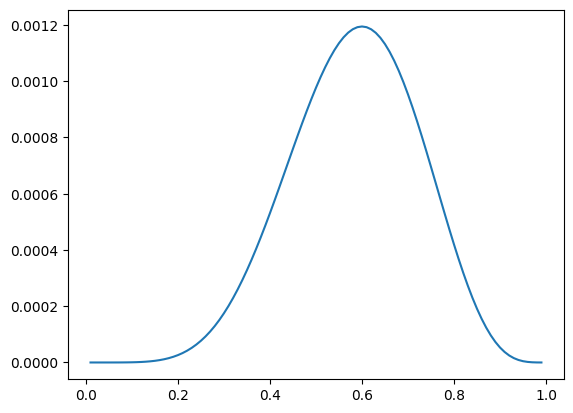

In [38]:
# コインを10回投げて，6回表が出た事象で，パラメータを横軸，尤度が縦軸のグラフを書いて．
x = np.arange(0.01, 1, 0.01)
y = []
for i in x:
    y.append(i**6 * (1 - i)**4)

plt.plot(x, y)
plt.show()

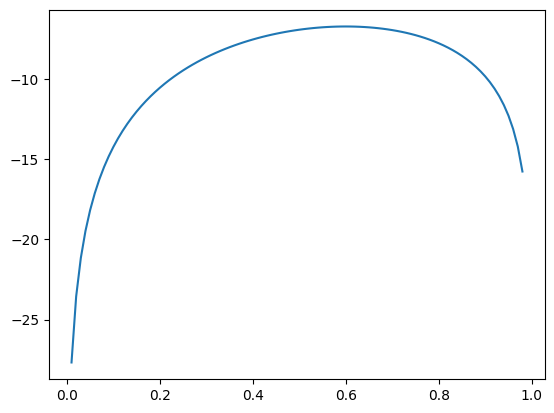

In [39]:
x = np.arange(0.01, 0.99, 0.01)
y = []
for i in x:
    y.append(
        6 * math.log(i) + 4 * math.log(1 - i)
        )

plt.plot(x, y)
plt.show()

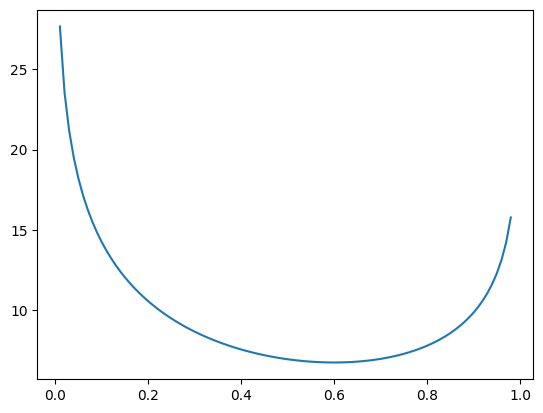

In [40]:
x = np.arange(0.01, 0.99, 0.01)
y = []
for i in x:
    y.append(
        - 6 * math.log(i) + - 4 * math.log(1 - i)
        )

plt.plot(x, y)
plt.show()

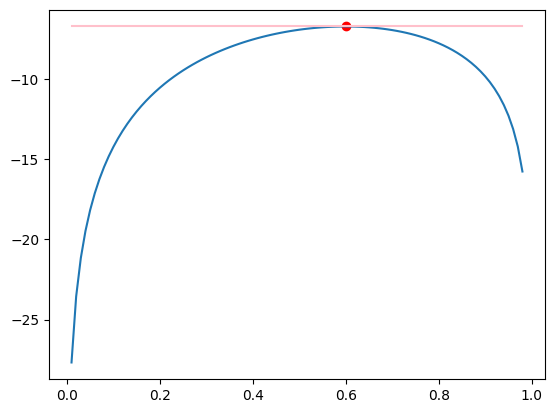

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import math

# xの範囲を設定
x = np.arange(0.01, 0.99, 0.01)

# 元の関数を計算（対数尤度として符号を反転）
y = []
for i in x:
    y.append(6 * math.log(i) + 4 * math.log(1 - i))

# 横軸の値が0.6のときの関数値を計算
x_tangent = 0.6
y_tangent = 6 * math.log(x_tangent) + 4 * math.log(1 - x_tangent)

# 関数の導関数を手動で計算（符号を反転）
def derivative(x):
    return 6/x - 4/(1 - x)

slope_tangent = derivative(x_tangent)

# 接線の方程式（y = mx + b）を設定
def tangent_line(x):
    return slope_tangent * (x - x_tangent) + y_tangent

# 計算した接線の値を取得
y_line = tangent_line(x)

# グラフを描画
plt.plot(x, y)
plt.plot(x, y_line, color='pink')
plt.scatter([x_tangent], [y_tangent], color='red')  # 点も描画

plt.show()

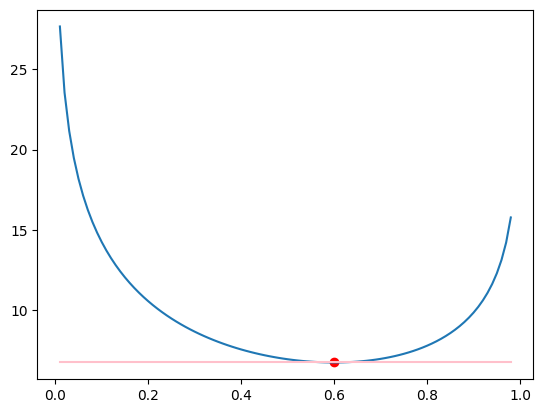

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import math

# xの範囲を設定
x = np.arange(0.01, 0.99, 0.01)

# 元の関数を計算
y = []
for i in x:
    y.append(-6 * math.log(i) - 4 * math.log(1 - i))

# 横軸の値が0.6のときの関数値を計算
x_tangent = 0.6
y_tangent = -6 * math.log(x_tangent) - 4 * math.log(1 - x_tangent)

# 関数の導関数を手動で計算
def derivative(x):
    return -6/x + 4/(1 - x)

slope_tangent = derivative(x_tangent)

# 接線の方程式（y = mx + b）を設定
def tangent_line(x):
    return slope_tangent * (x - x_tangent) + y_tangent

# 計算した接線の値を取得
y_line = tangent_line(x)

# グラフを描画
plt.plot(x, y, label='Original Function')
plt.plot(x, y_line, color='pink')
plt.scatter([x_tangent], [y_tangent], color='red')  # 点も描画
plt.show()

In [43]:
# p の範囲を設定（フレーム数を50に削減）
x = np.linspace(0.01, 0.99, 50)

# 負の対数尤度を計算
y = -6 * np.log(x) - 4 * np.log(1 - x)

# 図の設定
fig, ax = plt.subplots()

# 背景の負の対数尤度関数をプロット
line, = ax.plot(x, y)
ax.grid(True)
ax.set_ylim(0, 30)  # y 軸の範囲を設定

# アーティストリストの作成
artist_list = []

for p_opt in x:
    nll_p_opt = -6 * np.log(p_opt) - 4 * np.log(1 - p_opt)
    # 導関数（傾き）の計算
    dnll_p_opt = -6 / p_opt + 4 / (1 - p_opt)
    # 接線の描画範囲をプロット全体に設定
    x_tangent = np.linspace(min(x), max(x), 100)
    y_tangent = nll_p_opt + dnll_p_opt * (x_tangent - p_opt)
    # ポイントをプロット
    point = ax.plot(p_opt, nll_p_opt, 'ro')
    # 接線をプロット
    tangent_line, = ax.plot(x_tangent, y_tangent, color='pink', alpha=0.5)
    # フレームのアーティストをリストに追加
    artists = [line] + point + [tangent_line]
    artist_list.append(artists)

# アニメーションの作成
ani = ArtistAnimation(fig, artist_list, interval=100, blit=True)

plt.close()
HTML(ani.to_jshtml())
# ani.save('anim1.gif', writer="imagemagick")

### そもそも$\nabla E(\boldsymbol{w})$はどういう意味を持つのか．

$\nabla E(\boldsymbol{w})=X^{T}(\hat{\boldsymbol{y}}-\boldsymbol{y})$ではあるのだが，そもそもこれは何を表しているのかよくわからない．

まあ$\hat{\boldsymbol{y}}-\boldsymbol{y}$を考えると，いい感じの$\hat{\boldsymbol{y}}$が得られた場合はどうなるかというと，$\hat{\boldsymbol{y}}$の要素と，$\boldsymbol{y}$の要素の差が小さくなるはずなので，最終的な勾配の値が小さくなることは想像できる．

勾配は，ある点での損失関数の傾きを表している．

これは，どの方向に更新すれば良いかを示す．

### sigmoid関数のオーバーフロー問題

重みが局所解に収束してしまった時，重みが大きくなりすぎてしまうことがある．

実際に重みの更新をprintしてみると，以下のようになる．

```python
重みの初期値 [-0.68842949 -0.92671622  1.29033128]
更新された重み [-0.68842949 -0.92671622  1.29033128]
更新された重み [ 1.36840977  3.85742645 -3.08693048]
更新された重み [-3.63945613 -4.06670875  6.83698792]
更新された重み [ 150.85088124  176.5195338  -291.79248994]
更新された重み [-5638834.67679788 -6587762.2108836  10947290.95571537]
更新された重み [0. 0. 0.]
更新された重み [0.01616663 1.409684   0.01756403]
更新された重み [-0.33486555  2.43308407  0.0295918 ]
更新された重み [-0.92449465  3.57062831  0.04397982]
更新された重み [-1.66642173  4.78427471  0.06633156]
更新された重み [-2.34179647  5.81410109  0.08743725]
更新された重み [-2.68114522  6.32205947  0.09705944]
更新された重み [-2.73639496  6.40516044  0.09854532]
更新された重み [-2.7375669   6.40693805  0.09857682]
0.969
[-2.73756742  6.40693883  0.09857684]
scikit-learn-scratch/ssklearn/linear_model/_logistic_regression.py:31: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
scikit-learn-scratch/ssklearn/linear_model/_logistic_regression.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_new, _, _, _ = np.linalg.lstsq(
```

値が大きくなりすぎて，次の更新で0になっている．

0初期化と全く同じことをしている．

これは，シグモイド関数の内部で起きているオーバーフローが原因となっている．実際に確認してみる．

In [3]:
sample_x = -1000
print(np.exp(-sample_x))
print(1 / 1 + np.exp(-sample_x))

inf
inf


/var/folders/9x/ntmsqgq55glgc5365114c0v80000gn/T/ipykernel_96750/3529179393.py:2: RuntimeWarning: overflow encountered in exp
  print(np.exp(-sample_x))
/var/folders/9x/ntmsqgq55glgc5365114c0v80000gn/T/ipykernel_96750/3529179393.py:3: RuntimeWarning: overflow encountered in exp
  print(1 / 1 + np.exp(-sample_x))


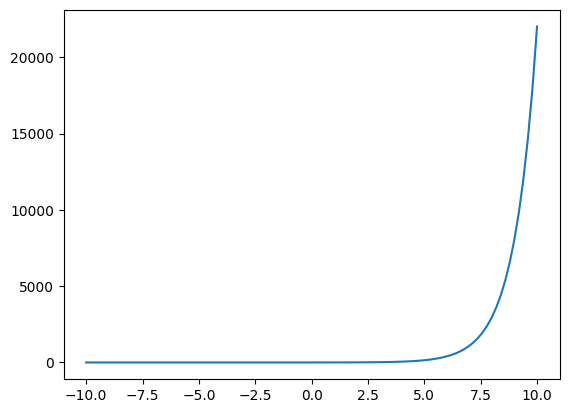

In [ ]:
# 指数関数のグラフを描画
x = np.linspace(-10, 10, 100)
y = np.exp(x)
plt.plot(x, y)
plt.show()

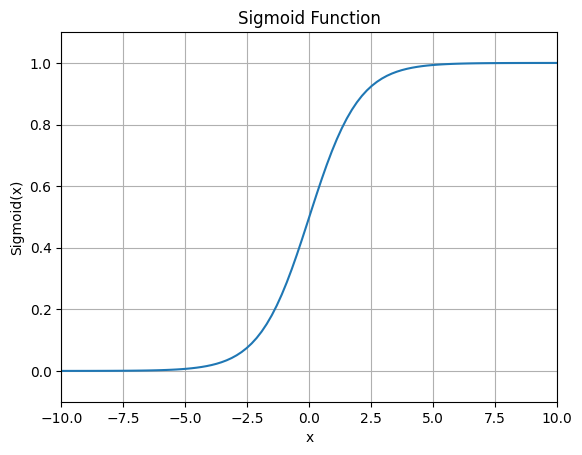

In [8]:
# シグモイド関数の描画
x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('Sigmoid(x)')
plt.xlim(-10, 10)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.show()

一行目はオーバーフローしているが，数式的にはOKである．なぜなら指数関数において，xが正に大きくなると無限大になる．

しかし，二行目はおかしい，分母が無限大になってしまっている．

注意するポイント
- infとinfの差はnanになる．
- infと0の差はinfになる．
- infと0の積は0になる．
- infとinfの積はnanになる．
などなど，ようはinfが絡むと最終的に出力される重みがnanになりやすい．

fitの計算過程を追ってみると，予測値 - 実測値の値がどうなっているかが肝になっていることがわかる．

これがinfになっているとまずダメだし，0や1に近すぎると対角行列の要素，pred * (1 - pred)を計算した時に0になってしまい，1 / rを計算した時に，0除算が発生してしまう．結果inf値がとんでいく．

つまり，pred * (1 - pred)が完全に0にならなければ良いということ．

そもそも0除算が入っているのはよくないが，数式的には0除算をなんとかしないといけないようなので，そこはプログラムで解決する．
 
\frac{1}{1+e^{-x}}
$$
であるため，xに負の値が入った時にオーバーフローを起こすということ，逆に言えば，正の値が入る分には，どのような値を入れたとしても0に収束するため，問題ない．

これを利用し，シグモイド関数を場合分けで実装する．

次に，シグモイド関数がどのような関数であったかを思い出す．

それは，横軸が正に進むと，縦軸が1に収束する関数，負に進むと，縦軸が0に収束する関数であった．

つまり指数がどのような値を取るかはあまり関係なく，1に収束するか，0に収束するかが重要である．

指数は負の方向に進むと0に収束するので，この性質をうまく使う．

xが限りなく大きい正の値を取るときを考える．

$$
\frac{1}{1+e^{-x}} \approx \frac{1}{1+0} = 1
$$

これは問題なく成り立つ．指数は負の方向に進むと0に収束するので，分母は1に収束する．

次にxが限りなく小さい負の値を取るときを考える．
$$
\frac{1}{1+e^{-x}} \approx \frac{1}{1+\infty} = 0
$$

これは数式的には問題ないが，pythonの計算では非常にまずい，これを計算すると結果はinfになる．

ということで，xが負の値をとったときに0になるようにシグモイド関数を加工する．

具体的には以下のようにする．

$$
\sigma(x) =
\begin{cases}
\frac{1}{1+e^{-x}} & (x \geq 0)\\
\frac{e^{x}}{1+e^{x}} & (x < 0)
\end{cases}
$$

正の値をとる時についてはこれまでと同じ，負の値をとったとき，$e^x$は0に収束しにいく．

実際に限りなく小さい負の値を入れると以下のようになる．

$$
\frac{e^{-x}}{1+e^{-x}} \approx \frac{0}{1+0} = 0
$$

これで，infになるのを回避してシグモイド関数を実装できた．

pythonで書くと以下のようになる．

```python
def sigmoid(x):
    return np.exp(np.minimum(x, 0)) / (1 + np.exp(- np.abs(x)))
```

In [ ]:
import numpy as np
from .._base import BaseClassifire


class LogisticRegressionBinary(BaseClassifire):
    def __init__(
        self,
        tol: float = 0.0001,
        max_iter: int = 100,
        fit_intercept: bool = True
    ):
        """logistic regression model."""
        self.tol = tol
        self.max_iter = max_iter
        self.fit_intercept = fit_intercept
        self.w = None
        self.iter = None


    @staticmethod
    def _sigmoid(x: np.ndarray) -> np.ndarray:
        """
        sigmoid function.

        Args:
            x (np.ndarray): Input data.

        Returns:
            np.ndarray: sigmoid function result.
        """
        return np.exp(np.minimum(x, 0)) / (1 + np.exp(- np.abs(x)))

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Training model using Newton method.

        Args:
            X (np.ndarray): Training data.
            y (np.ndarray): Target values.
        """
        if self.fit_intercept:
            X = np.insert(X, 0, 1, axis=1)
        self.w = np.random.randn(X.shape[1])
        # self.w = np.zeros(X.shape[1])
        print("重みの初期値", self.w)
        tol_vec = np.full(X.shape[1], self.tol)
        diff = np.full(X.shape[1], np.inf)
        self.iter = 0
        while np.any(diff > tol_vec) and (self.iter < self.max_iter):
            pred = self._sigmoid(np.dot(X, self.w))
            print("予測値\n", pred)
            print("更新された重み", self.w)
            r = pred * (1 - pred) + 1e-10
            print("r\n", r)
            xr = X.T * r
            xw = np.dot(X, self.w)
            r1 = (1 / r)
            print("r1\n", r1)
            w_new = np.dot((np.linalg.solve(np.dot(xr,X), xr)), (xw - (r1 * (pred - y))))
            diff = w_new - self.w
            self.iter += 1
            self.w = w_new

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict probability using the model.

        Args:
            X (np.ndarray): Samples.

        Returns:
            np.ndarray: Probability prediction results.
        """
        if self.fit_intercept:
            X = np.insert(X, 0, 1, axis=1)
        return self._sigmoid(np.dot(X, self.w))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict using the model.

        Args:
            X (np.ndarray): Samples.

        Returns:
            np.ndarray: Binary prediction results.
        """
        return (self.predict_proba(X) > 0.5).astype(int)



### 計算機epsilon

計算機において1より大きい数と1の差が最小の値を計算機epsilonという．

[wiki]('https://ja.wikipedia.org/wiki/%E8%A8%88%E7%AE%97%E6%A9%9F%E3%82%A4%E3%83%97%E3%82%B7%E3%83%AD%E3%83%B3)

In [9]:
import sys
print(sys.float_info.epsilon)

2.220446049250313e-16


### 参考

- [4.3.2-3：ロジスティック回帰の導出【PRMLのノート】](https://www.anarchive-beta.com/entry/2021/12/08/233612)
- [ヤコビ行列，ヤコビアンの定義と極座標の例](https://manabitimes.jp/math/1209)
- [ヤコビ行列](https://ja.wikipedia.org/wiki/%E3%83%A4%E3%82%B3%E3%83%93%E8%A1%8C%E5%88%97)
- [「ベクトルで微分・行列で微分」公式まとめ](https://qiita.com/AnchorBlues/items/8fe2483a3a72676eb96d)
- [ベクトルの微分](https://manabitimes.jp/math/2719)
- [パターン認識と機械学習 上](https://www.amazon.co.jp/%E3%83%91%E3%82%BF%E3%83%BC%E3%83%B3%E8%AA%8D%E8%AD%98%E3%81%A8%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92-%E4%B8%8A-C-M-%E3%83%93%E3%82%B7%E3%83%A7%E3%83%83%E3%83%97/dp/4621061224)
- [機械学習のエッセンス](https://www.sbcr.jp/product/4797393965/)

まだ，書いてないところの参考

- [ニュートン法はどのように収束していくのか – 1変数の場合で視覚化](https://automatic-browsing.com/%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%88%E3%83%B3%E6%B3%95%E3%81%AF%E3%81%A9%E3%81%AE%E3%82%88%E3%81%86%E3%81%AB%E5%8F%8E%E6%9D%9F%E3%81%97%E3%81%A6%E3%81%84%E3%81%8F%E3%81%AE%E3%81%8B-1%E5%A4%89/)
- [多変数のニュートン法の収束の様子を可視化](https://automatic-browsing.com/%e5%a4%9a%e5%a4%89%e6%95%b0%e3%81%ae%e3%83%8b%e3%83%a5%e3%83%bc%e3%83%88%e3%83%b3%e6%b3%95%e3%81%ae%e5%8f%8e%e6%9d%9f%e3%81%ae%e6%a7%98%e5%ad%90%e3%82%92%e5%8f%af%e8%a6%96%e5%8c%96/)
- [ニュートン法（1、2次元、多次元）](https://slpr.sakura.ne.jp/qp/rootfinding/)